   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Epoch [100/4000], MLP Loss: 0.1005, Fourier Loss: 0.1595
Epoch [200/4000], MLP Loss: 0.0424, Fourier Loss: 0.0520
Epoch [300/4000], MLP Loss: 0.0392, Fourier Loss: 0.0407
Epoch [400/4000], MLP Loss: 0.0388, Fourier Loss: 0.0395
Epoch [500/4000], MLP Loss: 0.0384, Fourier Loss: 0.0388
Epoch [600/4000], MLP Loss: 0.0380, Fourier Loss: 0.0382
Epoch [700/4000], MLP Loss: 0.0378, Fourier Loss: 0.0373
Epoch [800/4000], MLP Loss: 0.0375, Fourier Loss: 0.0354
Epoch [900/4000], MLP Loss: 0.0370, Fourier Loss: 0.0327
Epoch [1000/4000], MLP Loss: 0.0366, Fourier Loss: 0.0297
Epoch [1100/4000], MLP Loss: 0.0361, Fourier Loss: 0.0264
Epoch [120

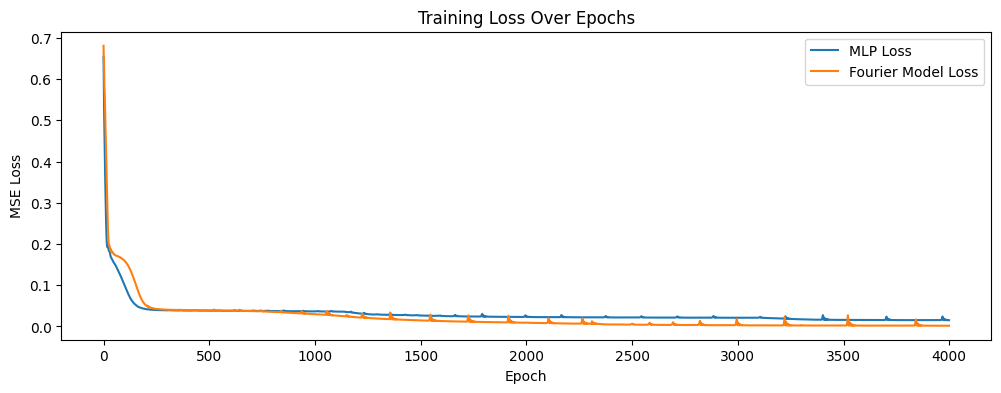

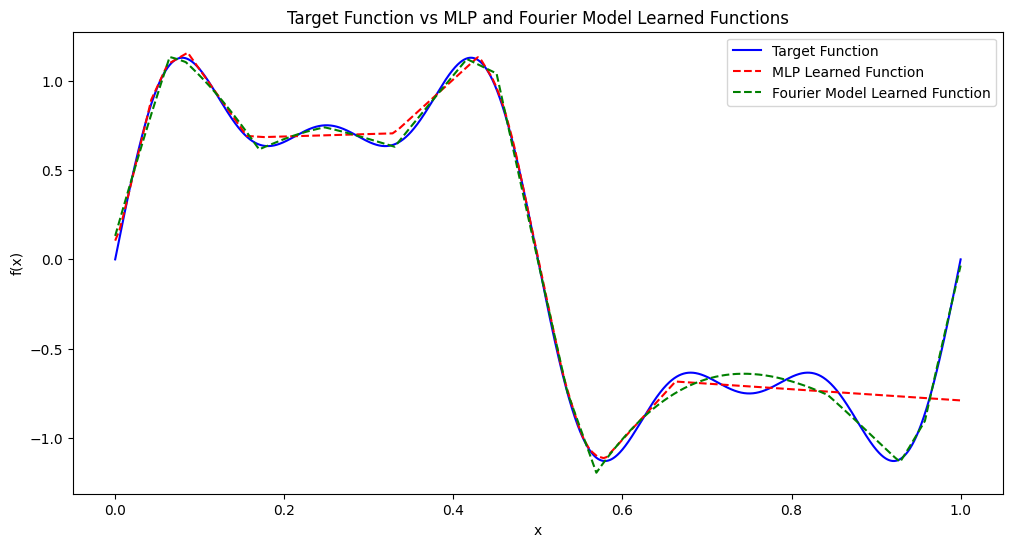

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the target function as the sum of 3 sinusoids
def target_function(x):
    return np.sin(2 * np.pi * 1.0 * x) + 0.5 * np.sin(2 * np.pi * 3.0 * x) + 0.25 * np.sin(2 * np.pi * 5.0 * x)

# Generate dataset with 4000 points
x = np.linspace(0, 1, 4000)  # 4000 points between 0 and 1
y = target_function(x)

# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the original 3-layer MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Define the LFF (Learnable Fourier Feature) layer
class LFF(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0, init="iso", sincos=False):
        super().__init__()
        self.in_features = in_features
        self.sincos = sincos
        self.out_features = out_features
        self.scale = scale
        if self.sincos:
            self.linear = nn.Linear(in_features, out_features // 2)
        else:
            self.linear = nn.Linear(in_features, out_features)
        if init == "iso":
            nn.init.normal_(self.linear.weight, 0, scale / in_features)
            nn.init.normal_(self.linear.bias, 0, 1)
        else:
            nn.init.uniform_(self.linear.weight, -scale / in_features, scale / in_features)
            nn.init.uniform_(self.linear.bias, -1, 1)
        if self.sincos:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = np.pi * self.linear(x)
        if self.sincos:
            return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        else:
            return torch.sin(x)

# Define the FourierModel with the LFF layer
class FourierModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(FourierModel, self).__init__()
        self.input_layer = LFF(state_dim, hidden_dim, scale=0.1, init="iso", sincos=False)
        self.mid_layer = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.mid_layer(x)
        x = self.relu2(x)
        return self.output(x)

# Initialize models, loss function, and optimizers
mlp_model = MLP()
fourier_model = FourierModel(state_dim=1, action_dim=1, hidden_dim=100)

criterion = nn.MSELoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.002)
fourier_optimizer = optim.Adam(fourier_model.parameters(), lr=0.002)

# Training loop for both models
num_epochs = 4000
mlp_losses = []
fourier_losses = []

for epoch in range(num_epochs):
    # Train MLP model
    mlp_model.train()
    mlp_optimizer.zero_grad()
    mlp_y_pred = mlp_model(x_train)
    mlp_loss = criterion(mlp_y_pred, y_train)
    mlp_loss.backward()
    mlp_optimizer.step()
    mlp_losses.append(mlp_loss.item())

    # Train Fourier model
    fourier_model.train()
    fourier_optimizer.zero_grad()
    fourier_y_pred = fourier_model(x_train)
    fourier_loss = criterion(fourier_y_pred, y_train)
    fourier_loss.backward()
    fourier_optimizer.step()
    fourier_losses.append(fourier_loss.item())

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], MLP Loss: {mlp_loss.item():.4f}, Fourier Loss: {fourier_loss.item():.4f}")

# Plot the training loss for both models
plt.figure(figsize=(12, 4))
plt.plot(mlp_losses, label="MLP Loss")
plt.plot(fourier_losses, label="Fourier Model Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Plot the target function vs. the learned functions
with torch.no_grad():
    mlp_y_learned = mlp_model(x_train).numpy()
    fourier_y_learned = fourier_model(x_train).numpy()

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Target Function", color='blue')
plt.plot(x, mlp_y_learned, label="MLP Learned Function", color='red', linestyle='--')
plt.plot(x, fourier_y_learned, label="Fourier Model Learned Function", color='green', linestyle='--')
plt.title("Target Function vs MLP and Fourier Model Learned Functions")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
